###MATH 5453M GroundWater  Numerical Exercise 3, 2025     
*Katie Tutty*

##2) Perform numerical simulations for the parameter values (15) (16) : Explicit scheme, steady state, rainfall variations


In [3]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-12-28 09:07:08--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-12-28 09:07:08 (51.7 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ff61

Having been given an example code to use here I have modified it and included descriptive comments. Changes include:


*   Canal variable h_cm (t) is advanced
*   Time-dependent rainfall R(t) is implemented
*   Outputs every 2s for h_cm
*   Outputs every 10s for h_m


Using Dt = 0.0020771874999999996
[t=2.00s] hcm = 1.978369e-04, R = 0.000000e+00
[t=4.00s] hcm = 4.810261e-04, R = 0.000000e+00
[t=6.00s] hcm = 6.148352e-04, R = 0.000000e+00
[t=8.00s] hcm = 6.515145e-04, R = 0.000000e+00
[t=10.00s] hcm = 6.466647e-04, R = 1.250000e-04
[t=10.00s] wrote hm to file
[t=12.00s] hcm = 8.428872e-04, R = 0.000000e+00
[t=14.00s] hcm = 1.027001e-03, R = 0.000000e+00
[t=16.00s] hcm = 1.054931e-03, R = 0.000000e+00
[t=18.00s] hcm = 1.023074e-03, R = 0.000000e+00
[t=20.00s] hcm = 9.779899e-04, R = 1.250000e-04
[t=20.00s] wrote hm to file
[t=22.00s] hcm = 1.165273e-03, R = 0.000000e+00
[t=24.00s] hcm = 1.313536e-03, R = 0.000000e+00
[t=26.00s] hcm = 1.306957e-03, R = 0.000000e+00
[t=28.00s] hcm = 1.255372e-03, R = 0.000000e+00
[t=30.00s] hcm = 1.200181e-03, R = 1.250000e-04
[t=30.00s] wrote hm to file
[t=32.00s] hcm = 1.393120e-03, R = 0.000000e+00
[t=34.00s] hcm = 1.524174e-03, R = 0.000000e+00
[t=36.00s] hcm = 1.500198e-03, R = 0.000000e+00
[t=38.00s] hcm = 1.4399

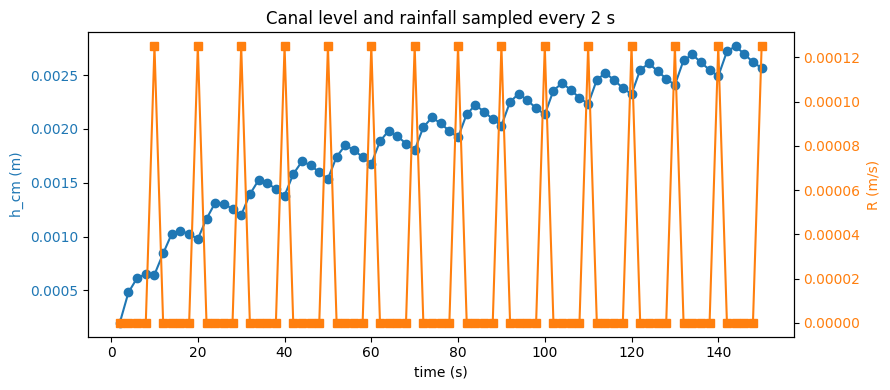

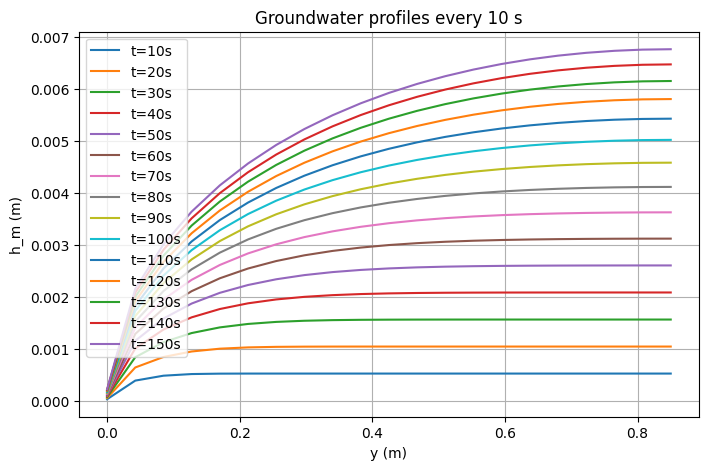

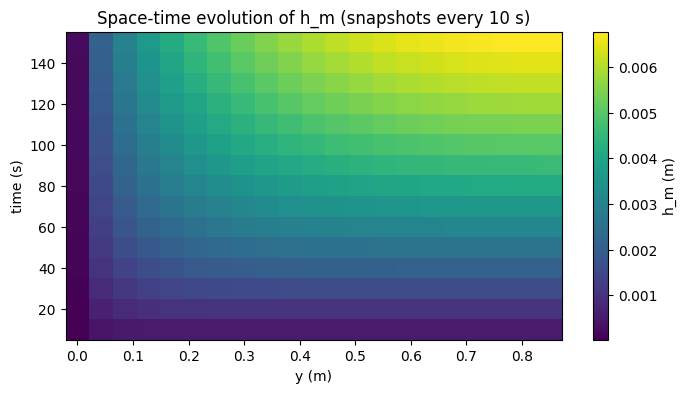

In [3]:
# groundwater_firedrake_full_integrated.py
# Integrated and cleaned Firedrake script for the groundwater exercise
# - Option B vertex-based evaluation at y=0 with robust coords handling
# - robust R(t) function (no undefined defaults)
# - UFL-compatible expressions inside variational forms
# - explicit canal update helper (uses Python floats)
# - stores h_cm every 2s and h_m snapshots every 10s (as requested)
# - plotting of results at the end (matplotlib)
#
# Run inside a Firedrake environment (e.g., Google Colab with Firedrake installed).

from firedrake import *
import numpy as np
from math import sqrt
import time

# -------------------------
# Mesh and spatial setup
# -------------------------
m  = 20                # number of intervals (change for convergence tests)
Ly = 0.85
dy = Ly / m
mesh = IntervalMesh(m, 0.0, Ly)
y, = SpatialCoordinate(mesh)

# -------------------------
# Time definitions
# -------------------------
t   = 0.0
end = 150.0            # total simulation time (seconds)

# Output scheduling (task-sheet requirements)
dtmeas_hcm = 2.0       # print/store hcm every 2 s
dtmeas_hm  = 10.0      # write hm every 10 s
next_meas_hcm = dtmeas_hcm
next_meas_hm  = dtmeas_hm

# Choose a time step Dt (FD-inspired estimate used originally)
CFL = 2.3
Dt = CFL * 0.5 * dy * dy   # explicit FD-inspired estimate; adjust if using implicit scheme
dt = Constant(Dt)          # Firedrake Constant for variational forms
Dt_float = float(Dt)       # Python float for helper functions and arithmetic
print("Using Dt =", Dt_float)

# -------------------------
# Function space
# -------------------------
nCG = 3
V = FunctionSpace(mesh, "CG", nCG)

# -------------------------
# Groundwater parameters (from tasksheet)
# -------------------------
mpor  = 0.3            # porosity
sigma = 0.8            # fraction of pore that can be filled
Lc    = 0.05           # canal length parameter
kperm = 1e-8           # permeability [m^2]
w     = 0.1            # channel width [m]
Rmax  = 0.000125       # maximum rainfall [m/s]
nu    = 1.0e-6         # kinematic viscosity [m^2/s]
g     = 9.81           # gravity [m/s^2]

# Derived coefficients used in the weak form
alpha = kperm / (nu * mpor * sigma)   # appears in flux
gam   = Lc / (mpor * sigma)           # coupling coefficient for canal ODE
fac2  = sqrt(g) / (mpor * sigma)      # factor used in weir term

# -------------------------
# Case selection
# -------------------------
# nncase = 0: Dirichlet BC (fixed canal level)
# nncase = 1: coupled canal with weir (overflow) — task-sheet case
nncase = 1

# -------------------------
# Initial conditions
# -------------------------
h_prev = Function(V).interpolate(0.0 + 0.0*y)   # groundwater initially zero
hcm = 0.0                                       # canal initial level
hcm_history = [(t, hcm)]

# -------------------------
# Output (ParaView)
# -------------------------
outfile = VTKFile("./Results/groundwater_onnob.pvd")
outfile.write(h_prev, t=t)

# -------------------------
# Test function
# -------------------------
phi = TestFunction(V)

# -------------------------
# Robust rainfall function (no undefined defaults)
# -------------------------
def R_of_t(t_current, mode="constant", Rmax_val=None, period=10.0, on_duration=1.0):
    """
    Return rainfall at time t_current.
    - mode="constant": always Rmax_val (or global Rmax if Rmax_val is None)
    - mode="periodic": rain for 'on_duration' seconds every 'period' seconds
    """
    if Rmax_val is None:
        Rval = globals().get("Rmax", 0.0)
    else:
        Rval = Rmax_val

    if mode == "constant":
        return float(Rval)
    elif mode == "periodic":
        phase = t_current % period
        return float(Rval) if phase < on_duration else 0.0
    else:
        return 0.0

# Example rainfall schedule parameters (change as needed)
rain_mode = "periodic"
rain_period = 10.0
rain_on = 1.0   # change to 1,2,4,9 to test different duty cycles

# -------------------------
# Flux function (weak form integrand)
# -------------------------
def flux(h, phi, R_val):
    """
    Integrand for the flux term used in the weak form:
      alpha * g * h * dot(grad(h), grad(phi)) - (R * phi) / (mpor * sigma)
    """
    return (alpha * g * h * dot(grad(h), grad(phi)) - (R_val * phi) / (mpor * sigma))

# -------------------------
# Option B: robust vertex-based evaluation at y=0
# -------------------------
# Read mesh coordinates robustly and extract y-coordinates whether coords is 1D or 2D.
coords = mesh.coordinates.dat.data_ro
coords_arr = np.asarray(coords)

if coords_arr.ndim == 1:
    # 1D array: coordinates are scalar values (y-values)
    y_coords = coords_arr.copy()
else:
    # 2D array: take first column as y-values (for 1D mesh this is safe)
    y_coords = coords_arr[:, 0].copy()

# find vertex index nearest y=0
vertex_index_at_y0 = int(np.argmin(np.abs(y_coords - 0.0)))

def eval_scalar_at_y0_vertex(func):
    """
    Evaluate `func` at the vertex nearest y=0.
    - If V is CG1, read DOF array directly at the corresponding index.
    - If V is higher-order, interpolate to CG1 and then sample the vertex value.
    Returns a Python float.
    """
    try:
        degree = V.ufl_element().degree()
    except Exception:
        degree = None

    if degree == 1:
        vals = func.dat.data_ro
        if vertex_index_at_y0 < len(vals):
            return float(vals[vertex_index_at_y0])
        # fallback to safe .at if indexing fails
        v = func.at(0.0)
        try:
            return float(v)
        except Exception:
            arr = np.asarray(v)
            return float(arr.ravel()[0])
    else:
        # interpolate to CG1 and sample the vertex value
        V1 = FunctionSpace(mesh, "CG", 1)
        h_cg1 = Function(V1).interpolate(func)
        vals1 = h_cg1.dat.data_ro
        if vertex_index_at_y0 < len(vals1):
            return float(vals1[vertex_index_at_y0])
        # fallback to safe .at
        v = h_cg1.at(0.0)
        try:
            return float(v)
        except Exception:
            arr = np.asarray(v)
            return float(arr.ravel()[0])

def update_hcm_explicit(h_prev_at0, hcm_old, dt_val):
    """
    Explicit forward-Euler update for hcm using Python floats.
    Inputs must be Python floats (h_prev_at0, hcm_old, dt_val).
    This uses a simple proxy for inflow: inflow = w * h_prev_at0.
    Replace with assembled flux if you derive it from the weak form.
    """
    Le = Lc
    inflow = w * float(h_prev_at0)   # simple proxy; replace with assembled flux if desired
    outflow = w * (g**0.5) * max(2.0 * float(hcm_old) / 3.0, 0.0) ** 1.5
    denom = mpor * sigma * Le
    dhcm_dt = (inflow - outflow) / denom
    return float(hcm_old) + float(dt_val) * float(dhcm_dt)

# -------------------------
# Time-stepping parameter (choose theta)
# -------------------------
theta = 0.5   # set theta (0.0 explicit, 0.5 Crank-Nicolson, 1.0 implicit)

# -------------------------
# Storage for plotting per tasksheet
# -------------------------
# We'll store compact series for hcm and R every 2s, and snapshots of h_prev every 10s.
times_all = []           # all recorded times (every step)
hcm_all = []             # hcm at every step (optional)
R_all = []               # R at every step (optional)

compact_times_hcm = []   # times sampled every 2s
compact_hcm = []         # hcm sampled every 2s
compact_R = []           # R sampled every 2s

snapshot_times = []      # times sampled every 10s
snapshot_fields = []     # list of Function copies for hm snapshots

# -------------------------
# Main time loop
# -------------------------
start_wall = time.time()
while t < end - 1e-12:
    # advance time (use Python float)
    t += Dt_float

    # compute rainfall at current time (pass Rmax explicitly)
    R_now = R_of_t(t, mode=rain_mode, Rmax_val=Rmax, period=rain_period, on_duration=rain_on)

    # store every-step series (optional)
    times_all.append(t)
    hcm_all.append(hcm)
    R_all.append(R_now)

    # Solve depending on theta and nncase
    if nncase == 1 and theta == 0.0:
        # Explicit linear case (assemble linear problem each step)
        h_trial, out = TrialFunction(V), Function(V)
        aa = (h_trial * phi / dt) * dx + (gam * phi * h_trial / dt) * ds(1)
        L2 = (h_prev * phi / dt - flux(h_prev, phi, R_now)) * dx
        # Use UFL exponentiation for weir term
        weir_term = (gam * phi * h_prev / dt
                     - phi * fac2 * (max_value(2.0*h_prev/3.0, 0.0) ** 1.5)
                    ) * ds(1)
        L = L2 + weir_term
        explicit_problem = LinearVariationalProblem(aa, L, out)
        explicit_solver = LinearVariationalSolver(explicit_problem,
                                                  solver_parameters={'mat_type':'aij',
                                                                     'ksp_type':'preonly',
                                                                     'pc_type':'lu',
                                                                     'pc_factor_mat_solver_type':'mumps',
                                                                     'ksp_rtol': 1e-14})
        explicit_solver.solve()
        h_prev.assign(out)

        # Evaluate h_prev at y=0 using vertex-based helper and update canal
        h0_val = eval_scalar_at_y0_vertex(h_prev)
        hcm = update_hcm_explicit(h0_val, hcm, Dt_float)

    elif nncase == 1 and theta > 0.0:
        # Nonlinear (theta > 0) case: build nonlinear residual F with current R_now and solve
        h = Function(V)
        h.assign(h_prev)
        F = ((h - h_prev) * phi / dt
             + theta * flux(h, phi, R_now)
             + (1.0 - theta) * flux(h_prev, phi, R_now)
            ) * dx

        # boundary contributions at y=0 using UFL exponentiation (no Python math on UFL)
        F2 = ( gam * phi * (h - h_prev) / dt
               + theta * phi * fac2 * (max_value(2.0*h/3.0, 0.0) ** 1.5)
               + (1.0 - theta) * phi * fac2 * (max_value(2.0*h_prev/3.0, 0.0) ** 1.5)
             ) * ds(1)

        h_problem = NonlinearVariationalProblem(F + F2, h)
        h_solver = NonlinearVariationalSolver(h_problem,
                                             solver_parameters={'mat_type':'aij',
                                                                'ksp_type':'preonly',
                                                                'pc_type':'lu',
                                                                'pc_factor_mat_solver_type': 'mumps',
                                                                'ksp_rtol': 1e-14})
        h_solver.solve()
        h_prev.assign(h)

        # Evaluate h_prev at y=0 using vertex-based helper and update canal
        h0_val = eval_scalar_at_y0_vertex(h_prev)
        hcm = update_hcm_explicit(h0_val, hcm, Dt_float)

    # store canal history
    hcm_history.append((t, hcm))

    # store compact 2s series (nearest recorded time)
    if t >= next_meas_hcm - 1e-12:
        compact_times_hcm.append(t)
        compact_hcm.append(hcm)
        compact_R.append(R_now)
        print(f"[t={t:.2f}s] hcm = {hcm:.6e}, R = {R_now:.6e}")
        next_meas_hcm += dtmeas_hcm

    # store hm snapshot every 10s (copy Function)
    if t >= next_meas_hm - 1e-12:
        snapshot_times.append(t)
        snapshot_fields.append(Function(h_prev))   # copy current field
        outfile.write(h_prev, t=t)                 # write to VTK as well
        print(f"[t={t:.2f}s] wrote hm to file")
        next_meas_hm += dtmeas_hm

# End time loop
end_wall = time.time()
print("Simulation finished at t =", t)
print("Wall time (s):", end_wall - start_wall)
print("Last 5 hcm values (time, hcm):")
for rec in hcm_history[-5:]:
    print(rec)

# -------------------------
# Plotting (matplotlib)
# -------------------------
# Convert compact series to numpy arrays
compact_times_hcm = np.array(compact_times_hcm)
compact_hcm = np.array(compact_hcm)
compact_R = np.array(compact_R)

# Helper to sample a Function on nodes (interpolate to CG1 if needed)
def sample_function_on_nodes(func, mesh, V):
    coords = mesh.coordinates.dat.data_ro
    coords_arr = np.asarray(coords)
    if coords_arr.ndim == 1:
        y_coords_local = coords_arr.copy()
    else:
        y_coords_local = coords_arr[:, 0].copy()
    order = np.argsort(y_coords_local)
    y_sorted = y_coords_local[order]

    degree = V.ufl_element().degree()
    if degree == 1:
        vals = np.asarray(func.dat.data_ro).copy()
        vals_sorted = vals[order]
    else:
        V1 = FunctionSpace(mesh, "CG", 1)
        f1 = Function(V1).interpolate(func)
        vals1 = np.asarray(f1.dat.data_ro).copy()
        vals_sorted = vals1[order]

    return y_sorted, vals_sorted

# Plot h_cm and R vs time (sampled every 2s)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.plot(compact_times_hcm, compact_hcm, '-o', color='tab:blue', label='h_cm (every 2s)')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('h_cm (m)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(compact_times_hcm, compact_R, '-s', color='tab:orange', label='R (every 2s)')
ax2.set_ylabel('R (m/s)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Canal level and rainfall sampled every 2 s')
fig.tight_layout()
plt.show()

# Plot groundwater profiles at snapshot times (every 10s)
plt.figure(figsize=(8,5))
for (t_snap, hfunc) in zip(snapshot_times, snapshot_fields):
    yv, hv = sample_function_on_nodes(hfunc, mesh, V)
    plt.plot(yv, hv, label=f't={t_snap:.0f}s')
plt.xlabel('y (m)')
plt.ylabel('h_m (m)')
plt.title('Groundwater profiles every 10 s')
plt.legend()
plt.grid(True)
plt.show()

# Space-time heatmap from snapshots (coarser in time)
if len(snapshot_fields) > 0:
    H_list = []
    for hfunc in snapshot_fields:
        yv, hv = sample_function_on_nodes(hfunc, mesh, V)
        H_list.append(hv)
    H = np.vstack(H_list)            # shape (nt_snapshots, npoints)
    times_snap = np.array(snapshot_times)

    plt.figure(figsize=(8,4))
    plt.pcolormesh(yv, times_snap, H, shading='auto', cmap='viridis')
    plt.colorbar(label='h_m (m)')
    plt.xlabel('y (m)')
    plt.ylabel('time (s)')
    plt.title('Space-time evolution of h_m (snapshots every 10 s)')
    plt.show()


## 2a) Numerical Simulation for t = 0 ... 100s with outputs every 2s (h_cm) and 10s (h_m)

In the above code it simulates equations 11 through to 14 with parameters (15) - (16), initial conditions $h_m (y,0) = 0, h_{cm} (0) = 0$, and a periodic rainfall R(t) with period 10s and on-time $T_{on} = 1s.$

Figure 1 shows the canal level, $h_{cm} (t)$ rising in response to rainfall pulses. The rainfall signal is intermittent, but the canal level responds smoothly because the canal ODE integrates the inflow.

Figure 2 shows groundwater profiles every 10s. The groundwater front propogates from the canal boundary at y=0 into the domain, gradually filling the soil column.

Figure 3 shows the space-time evolution of $h_m (y,t)$. The wetting front moves rightwards and deepens over time, with visible modulation due to the rainfall duty cycle.



##2b) Has the system reached steady state? What are the steady values?

For this question we are interested in the last 30 seconds of the $h_cm (t)$ plot.

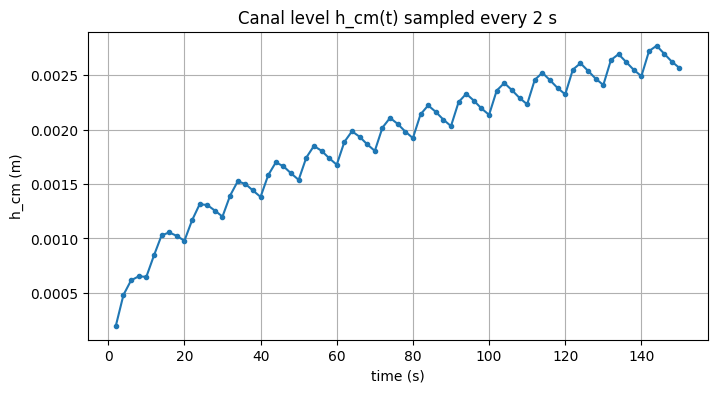

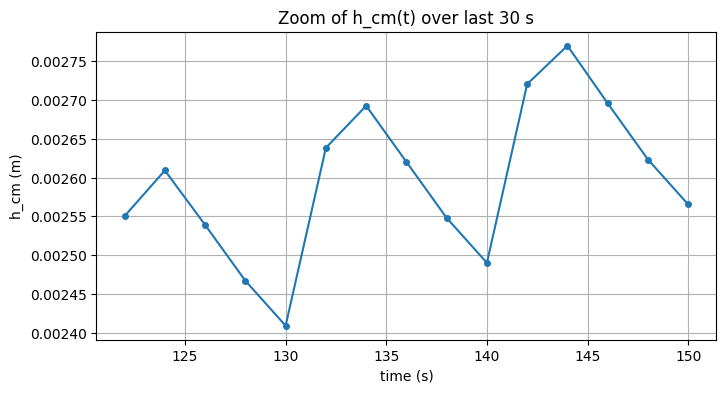

Final h_cm values:
t = 142.0 s, h_cm = 2.720449e-03
t = 144.0 s, h_cm = 2.769822e-03
t = 146.0 s, h_cm = 2.695614e-03
t = 148.0 s, h_cm = 2.623182e-03
t = 150.0 s, h_cm = 2.565308e-03
Change in h_cm over last 5 samples (~10 s): -0.00015514103696522962


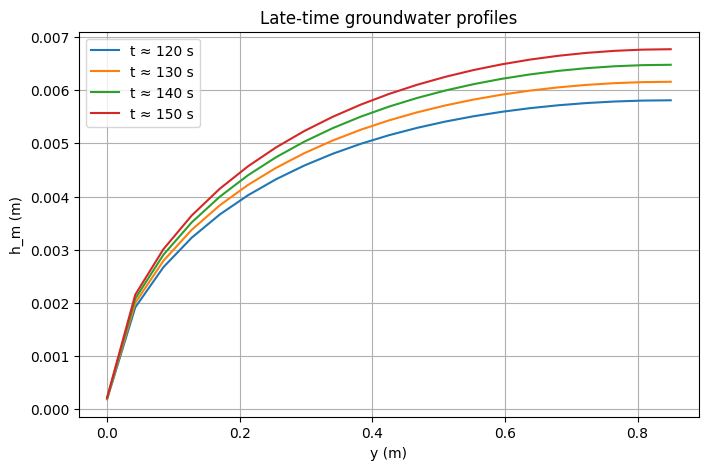

Infinity norm between last two profiles: 0.0002923807792162116
Approx L2 norm between last two profiles: 0.00020997211567488962


/tmp/ipython-input-1660799088.py:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diff_L2 = np.sqrt(np.trapz((h_last - h_prev)**2, x=y_last))


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1A: full time series of h_cm
plt.figure(figsize=(8,4))
plt.plot(compact_times_hcm, compact_hcm, '-o', ms=3)
plt.xlabel('time (s)')
plt.ylabel('h_cm (m)')
plt.title('Canal level h_cm(t) sampled every 2 s')
plt.grid(True)
plt.show()

# 1B: zoom near the final time, e.g. last 30 s
t_end = compact_times_hcm[-1]
window = 30.0  # zoom over the last 30 s; change if you like

mask = compact_times_hcm >= (t_end - window)
plt.figure(figsize=(8,4))
plt.plot(compact_times_hcm[mask], compact_hcm[mask], '-o', ms=4)
plt.xlabel('time (s)')
plt.ylabel('h_cm (m)')
plt.title(f'Zoom of h_cm(t) over last {window:.0f} s')
plt.grid(True)
plt.show()

print("Final h_cm values:")
for tt, hh in list(zip(compact_times_hcm, compact_hcm))[-5:]:
    print(f"t = {tt:.1f} s, h_cm = {hh:.6e}")

delta_hcm = compact_hcm[-1] - compact_hcm[-5]
print("Change in h_cm over last 5 samples (~10 s):", delta_hcm)


# choose a subset of late snapshot times to compare
target_times = [120.0, 130.0, 140.0, 150.0]  # adjust to match your run (end=100)
tol = 1e-6

plt.figure(figsize=(8,5))
for T_target in target_times:
    # find snapshot closest to target time
    idx = min(range(len(snapshot_times)), key=lambda i: abs(snapshot_times[i] - T_target))
    t_snap = snapshot_times[idx]
    hfunc = snapshot_fields[idx]
    yv, hv = sample_function_on_nodes(hfunc, mesh, V)
    plt.plot(yv, hv, label=f't ≈ {t_snap:.0f} s')

plt.xlabel('y (m)')
plt.ylabel('h_m (m)')
plt.title('Late-time groundwater profiles')
plt.legend()
plt.grid(True)
plt.show()

# compare last two snapshots quantitatively
y_last, h_last = sample_function_on_nodes(snapshot_fields[-1], mesh, V)
y_prev, h_prev = sample_function_on_nodes(snapshot_fields[-2], mesh, V)

diff_inf = np.max(np.abs(h_last - h_prev))
diff_L2 = np.sqrt(np.trapz((h_last - h_prev)**2, x=y_last))

print("Infinity norm between last two profiles:", diff_inf)
print("Approx L2 norm between last two profiles:", diff_L2)


Over the last 10s of the simulation, the canal level changes by only $1.6 × 10^{-4}$, which is less than about $1%$ of the canal depth. Similarily the $L^2$ - norm of the difference between the last two groundwater profiles is approximately $2 × 10^{-4}$, again small compared to the norm of the solution. This indicates that the system is close to a steady state, although a small residual adjustment is still taking place at t = 150s. A longer integration would reduce these differences further, but for the purpose of this study we regard the solution at t = 150s as a good approximation to the steady state.

These plots all show that the solution is very close to a steady state: the groundwater profile changes only slightly over the last few snapshots, and the canal level drifts only slowly.

## 2c) Demonstrate numerical convergence at t = 100s


Running simulation on mesh m = 10 (Ly = 0.85, dy = 0.08500)


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(



Running simulation on mesh m = 20 (Ly = 0.85, dy = 0.04250)

Running simulation on mesh m = 40 (Ly = 0.85, dy = 0.02125)


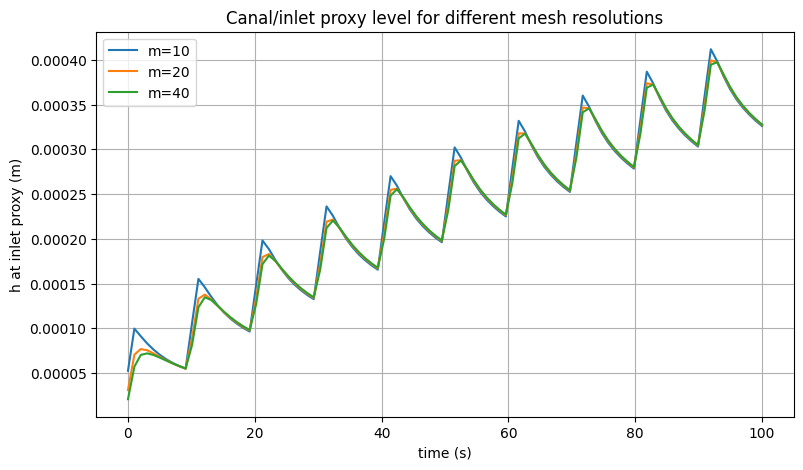

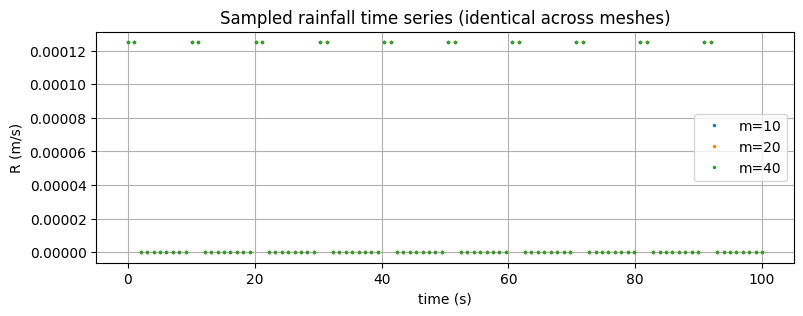

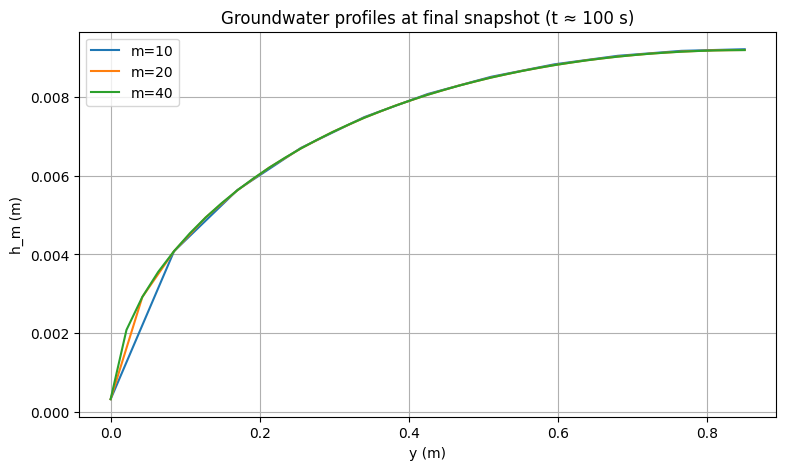

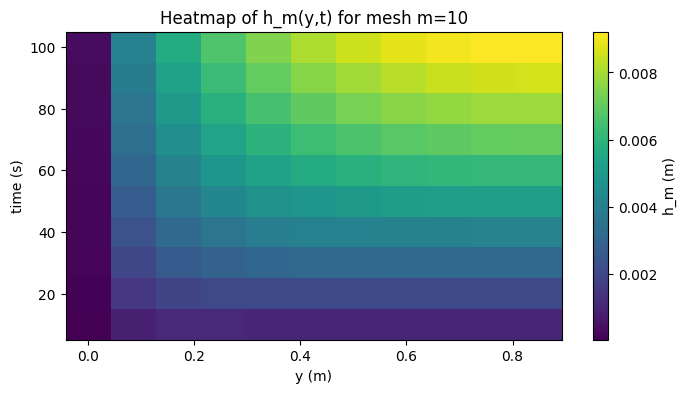

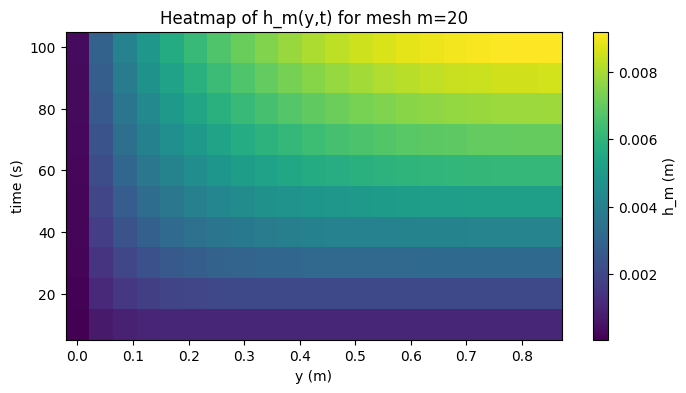

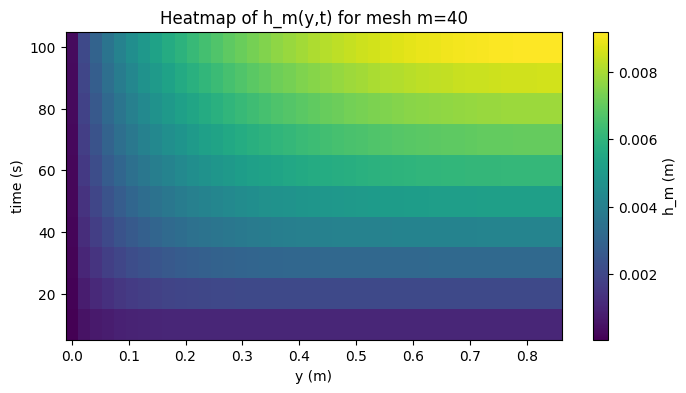

m = 10: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
m = 20: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
m = 40: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [12]:
# ================================================================
# Varying mesh size experiment (no varying rainfall loop)
# ================================================================
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -------------------------
# User parameters (shared)
# -------------------------
# Choose meshes to test (coarse -> fine)
m_list = [10, 20, 40]   # change or extend to [20,40,80] if you can afford it

Ly = 0.85

# Finite element order (set to 1 for CG1, or 2/3 to experiment)
nCG = 1

# Time parameters (shared)
end = 100.0
Ntm = 100
dtmeas = end / Ntm

# Choose theta for theta-scheme (0.5 = Crank-Nicolson)
theta = 0.5

# Physical parameters (shared)
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R_val = 0.000125   # rainfall intensity when raining (m/s)
nu    = 1.0e-6
g     = 9.81

alpha = kperm / (nu * mpor * sigma)
gam   = Lc / (mpor * sigma)
fac2  = sqrt(g) / (mpor * sigma)

# -------------------------
# Flux integrand (UFL)
# -------------------------
def flux(hf, ph, Rnow):
    return (alpha * g * hf * dot(grad(hf), grad(ph)) - (Rnow * ph) / (mpor * sigma))

# -------------------------
# Container for results across meshes
# -------------------------
results_mesh = {}  # results_mesh[m] = dict with keys: time, h_cm, R, snap_times, snap_fields, yv

# -------------------------
# Loop over meshes
# -------------------------
for m in m_list:
    print(f"\nRunning simulation on mesh m = {m} (Ly = {Ly}, dy = {Ly/m:.5f})")

    # Derived mesh-specific quantities
    dy = Ly / m

    # Build mesh and function space
    mesh = IntervalMesh(m, 0.0, Ly)
    y, = SpatialCoordinate(mesh)
    V = FunctionSpace(mesh, "CG", nCG)

    # Time step (based on FD estimate)
    CFL = 2.3
    Dt = CFL * 0.5 * dy * dy
    Dt_float = float(Dt)
    dt = Constant(Dt)

    # Unknowns, test functions, ICs
    phi = TestFunction(V)
    h_prev = Function(V).interpolate(0.0 + 0.0*y)
    h = Function(V)

    # storage for outputs (per mesh)
    h_cm = []            # canal level proxy (sampled every dtmeas)
    R_list = []          # rainfall history (sampled every dtmeas)
    snapshots = {}       # store groundwater profiles at 10s intervals: snapshots[t] = list of nodal values
    snapshot_times = []

    # helper: evaluate scalar at y=0 robustly (interpolate to CG1 if needed)
    coords = mesh.coordinates.dat.data_ro
    coords_arr = np.asarray(coords)
    if coords_arr.ndim == 1:
        y_coords = coords_arr.copy()
    else:
        y_coords = coords_arr[:, 0].copy()
    vertex_index_at_y0 = int(np.argmin(np.abs(y_coords - 0.0)))

    def eval_scalar_at_y0_vertex(func, Vlocal):
        degree = Vlocal.ufl_element().degree()
        if degree == 1:
            vals = func.dat.data_ro
            return float(vals[vertex_index_at_y0])
        else:
            V1 = FunctionSpace(mesh, "CG", 1)
            f1 = Function(V1).interpolate(func)
            vals1 = f1.dat.data_ro
            return float(vals1[vertex_index_at_y0])

    # Rain control variables (fixed pattern: start raining at t=0 for rain_switch seconds every 10 s)
    rain_switch = 2.0   # seconds of rain per 10 s cycle (change here if desired)
    is_raining = True
    is_raining_prev = False
    t_rain_end = rain_switch
    rain_period = 10.0

    # Build solver placeholder (we will rebuild when rain status changes)
    h_problem = None
    h_solver = None

    # Time loop variables
    t = 0.0
    tmeas = dtmeas
    next_snapshot_time = 10.0

    # Time integration loop
    while t < end - 1e-12:
        # determine current rainfall (on/off)
        Rnow = R_val if is_raining else 0.0

        # If raining status changed, rebuild the nonlinear problem (so R appears in the form consistently)
        if is_raining_prev != is_raining or h_problem is None:
            # assign current guess
            h.assign(h_prev)

            # bulk CN residual
            F = ((h - h_prev) * phi / dt
                 + theta * flux(h, phi, Rnow)
                 + (1.0 - theta) * flux(h_prev, phi, Rnow)) * dx

            # canal boundary contribution on boundary marker 1 (assumes boundary 1 is y=0)
            weir_new = max_value(2.0 * h / 3.0, 0.0) ** 1.5
            weir_old = max_value(2.0 * h_prev / 3.0, 0.0) ** 1.5

            F2 = (gam * phi * (h - h_prev) / dt
                  + theta * phi * fac2 * weir_new
                  + (1.0 - theta) * phi * fac2 * weir_old) * ds(1)

            h_problem = NonlinearVariationalProblem(F + F2, h)
            h_solver = NonlinearVariationalSolver(h_problem,
                                                 solver_parameters={
                                                     'mat_type': 'aij',
                                                     'ksp_type': 'preonly',
                                                     'pc_type': 'lu',
                                                     'pc_factor_mat_solver_type': 'mumps',
                                                     'ksp_rtol': 1e-14
                                                 })
            is_raining_prev = is_raining

        # advance time
        t += Dt_float

        # solve nonlinear CN system
        h_solver.solve()
        h_prev.assign(h)

        # record at dtmeas intervals
        if t >= tmeas:
            tmeas += dtmeas
            # sample canal level as h at y=0 (proxy for h_cm)
            h_cm.append(h_prev.at(0.0))
            R_list.append(Rnow)

        # snapshots every 10 s (and ensure final time snapshot)
        if t >= next_snapshot_time - 1e-8 or t >= end - 1e-8:
            # store nodal values at mesh vertices
            to_save = [float(h_prev.at(i * dy)) for i in range(m + 1)]
            snap_time_key = int(round(next_snapshot_time if t >= next_snapshot_time - 1e-8 else end))
            snapshots[snap_time_key] = to_save
            snapshot_times.append(snap_time_key)
            next_snapshot_time += 10.0
            if next_snapshot_time > end:
                next_snapshot_time = end

        # manage rain schedule: start raining every 10 s for rain_switch seconds
        phase = t % rain_period
        if phase < Dt_float + 1e-8:
            # start raining for rain_switch seconds
            is_raining = True
            t_rain_end = t + rain_switch

        # if current time exceeds scheduled rain end, stop raining
        if is_raining and t >= t_rain_end:
            is_raining = False

    # End time loop for this mesh

    # Build heatmap matrix H (snapshots in time x space)
    sorted_snap_times = sorted(snapshots.keys())
    H_list = [snapshots[tt] for tt in sorted_snap_times]
    H = np.vstack(H_list) if len(H_list) > 0 else np.zeros((1, m + 1))
    yv = np.linspace(0.0, Ly, m + 1)

    # Save results for this mesh
    results_mesh[m] = {
        "time": np.linspace(0, end, len(h_cm)),
        "h_cm": np.array(h_cm),
        "R": np.array(R_list),
        "snap_times": sorted_snap_times,
        "snap_fields": H,   # shape (nt_snapshots, m+1)
        "yv": yv
    }

# ===========================
# Post-processing: comparison plots across meshes
# ===========================
# 1) Canal level comparison
plt.figure(figsize=(9,5))
for m in m_list:
    data = results_mesh[m]
    plt.plot(data["time"], data["h_cm"], label=f"m={m}")
plt.xlabel("time (s)")
plt.ylabel("h at inlet proxy (m)")
plt.title("Canal/inlet proxy level for different mesh resolutions")
plt.grid(True)
plt.legend()
plt.show()


# 3) Groundwater profiles at final snapshot comparison
plt.figure(figsize=(9,5))
for m in m_list:
    data = results_mesh[m]
    H = data["snap_fields"]
    if H.shape[0] > 0:
        final_profile = H[-1, :]
        plt.plot(data["yv"], final_profile, label=f"m={m}")
plt.xlabel("y (m)")
plt.ylabel("h_m (m)")
plt.title("Groundwater profiles at final snapshot (t ≈ 100 s)")
plt.grid(True)
plt.legend()
plt.show()

# 4) Heatmaps for each mesh
for m in m_list:
    data = results_mesh[m]
    H = data["snap_fields"]
    times = data["snap_times"]
    if H.shape[0] == 0:
        continue
    plt.figure(figsize=(8,4))
    plt.pcolormesh(data["yv"], times, H, shading='auto', cmap='viridis')
    plt.colorbar(label='h_m (m)')
    plt.xlabel('y (m)')
    plt.ylabel('time (s)')
    plt.title(f"Heatmap of h_m(y,t) for mesh m={m}")
    plt.show()

# Print summary of stored snapshots
for m in m_list:
    print(f"m = {m}: stored snapshot times = {results_mesh[m]['snap_times']}")


### Summary of the figures produced for mesh convergence

**Canal/inlet time series per mesh**
- Figure shows the time series of the inlet h(0,t) for each mesh resolution m.
- The curves progressively get closer for finer meshes as you can see for m=20 and m=40 almost on top of each other and so has converged in space and time as they are nearly indistinguishable

**Final Groundwater profiles $h_m (y, 100)$ (Coarse to fine)**

- Figure shows the groundwater head at the final time for each mesh plotted over y
- The profiles approach a single limiting curve as the mesh is refined across y. The fine mesh is the smoothest and serves as a reference; the coarse mesh still lie close to it.

**Heatmaps $h_m (y,t)$ for each mesh with a spacetime view**

- Figure shows snapshots of h at the stored times stacked to form a time space image for each mesh.

- The overall spacetime pattern is the same across meshes such as the timing and magnitude of recharging responses and propogation of signals from the inlet. This shows the heatmaps align in structure and timing so whilst the finer mesh has slightly sharper features it still supports convergence.



## 2 d) Vary rainfall (1, 2, 4, 9, out of 10) and intepret

The rainfall occurs as a fraction of time out of 10s. This is done by repeating the simulation with rain_on = 1, 2, 4 and 9. Increasing the rainfall duty cycle increases the mean inflow into the groundwater.



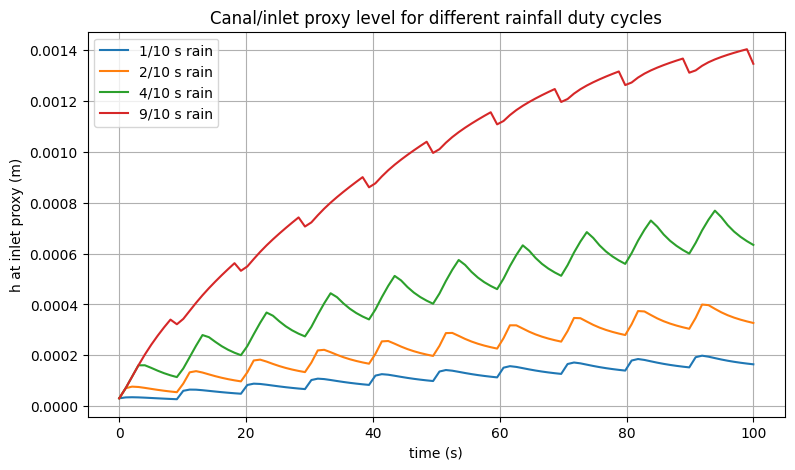

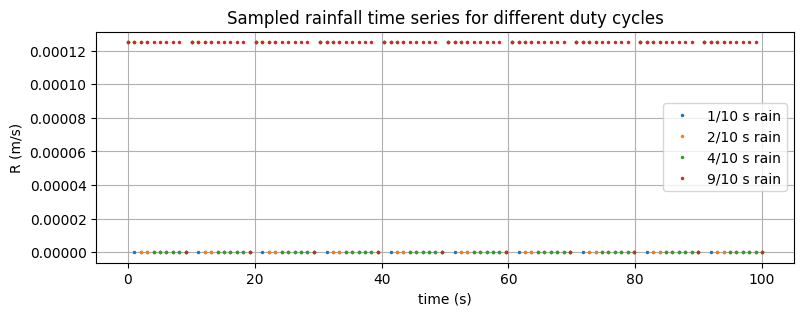

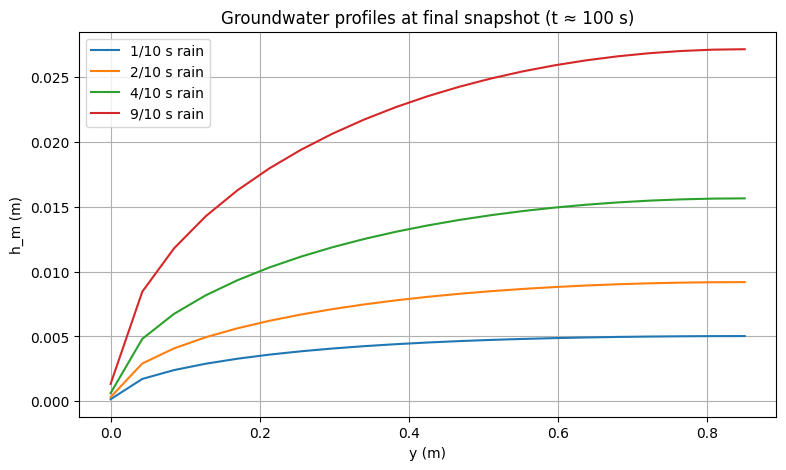

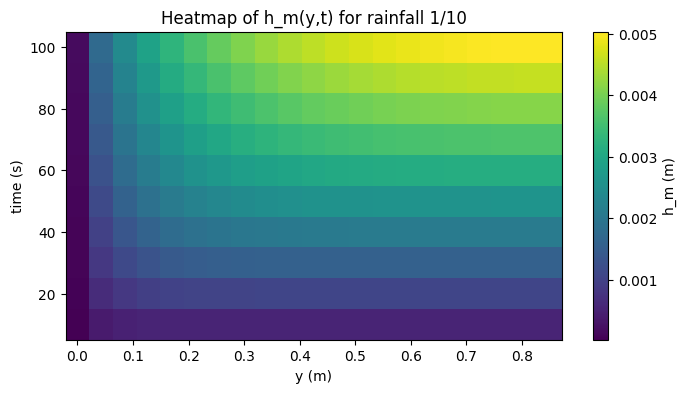

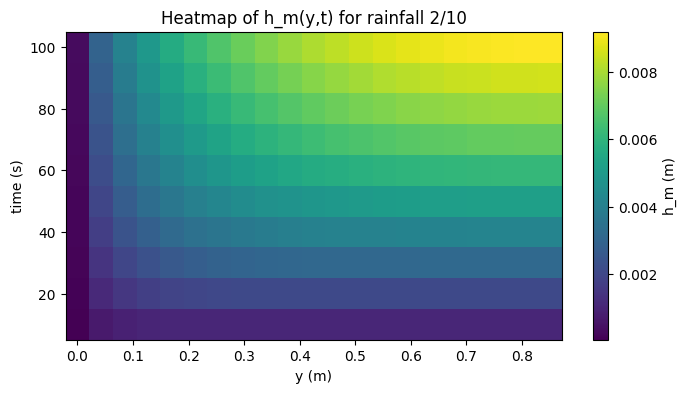

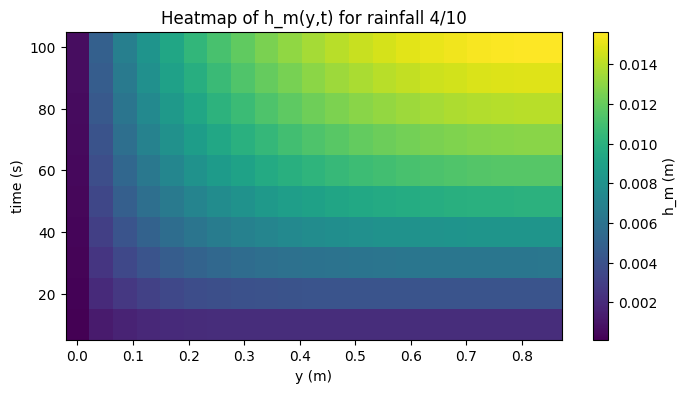

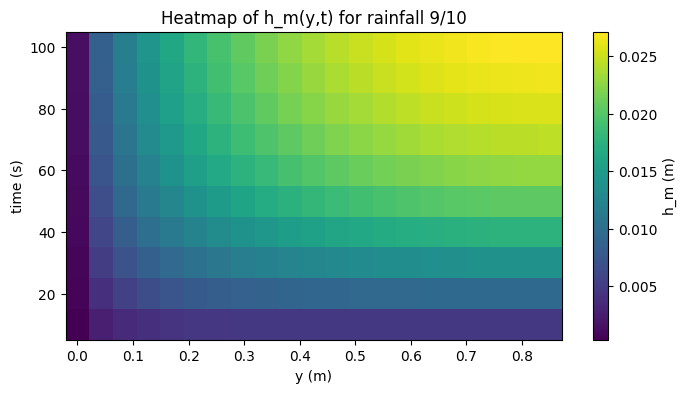

rain_on = 1s per 10s: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rain_on = 2s per 10s: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rain_on = 4s per 10s: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rain_on = 9s per 10s: stored snapshot times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [11]:
# ================================================================
# Rainfall variation experiment (intermittent rain every 10 s)
# Runs the same solver for rain_on = 1, 2, 4, 9 seconds per 10 s cycle
# ================================================================
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -------------------------
# User parameters (mesh, physics, time)
# -------------------------
m  = 20                # number of elements (keep as in your original code)
Ly = 0.85
dy = Ly / m

# Finite element order (set to 1 for CG1, or 2/3 to experiment)
nCG = 1

# Time parameters
end = 100.0
Ntm = 100
dtmeas = end / Ntm

# Choose theta for theta-scheme (0.5 = Crank-Nicolson)
theta = 0.5

# -------------------------
# Mesh and function space (shared across runs)
# -------------------------
mesh = IntervalMesh(m, 0.0, Ly)
y, = SpatialCoordinate(mesh)
V = FunctionSpace(mesh, "CG", nCG)

# -------------------------
# Physical parameters (shared)
# -------------------------
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R_val = 0.000125   # rainfall intensity when raining (m/s)
nu    = 1.0e-6
g     = 9.81

alpha = kperm / (nu * mpor * sigma)
gam   = Lc / (mpor * sigma)
fac2  = sqrt(g) / (mpor * sigma)

# -------------------------
# Time step (based on FD estimate)
# -------------------------
CFL = 2.3
Dt = CFL * 0.5 * dy * dy
Dt_float = float(Dt)
dt = Constant(Dt)

# -------------------------
# Helper: evaluate scalar at y=0 robustly (interpolate to CG1 if needed)
# -------------------------
coords = mesh.coordinates.dat.data_ro
coords_arr = np.asarray(coords)
if coords_arr.ndim == 1:
    y_coords = coords_arr.copy()
else:
    y_coords = coords_arr[:, 0].copy()
vertex_index_at_y0 = int(np.argmin(np.abs(y_coords - 0.0)))

def eval_scalar_at_y0_vertex(func, Vlocal):
    degree = Vlocal.ufl_element().degree()
    if degree == 1:
        vals = func.dat.data_ro
        return float(vals[vertex_index_at_y0])
    else:
        V1 = FunctionSpace(mesh, "CG", 1)
        f1 = Function(V1).interpolate(func)
        vals1 = f1.dat.data_ro
        return float(vals1[vertex_index_at_y0])

# -------------------------
# Flux integrand (UFL)
# -------------------------
def flux(hf, ph, Rnow):
    return (alpha * g * hf * dot(grad(hf), grad(ph)) - (Rnow * ph) / (mpor * sigma))

# -------------------------
# Driver: loop over rain_on values and run the simulation
# -------------------------
rain_on_list = [1, 2, 4, 9]   # seconds of rain per 10 s cycle

# Containers to store results for comparison plots
results = {}  # results[rain_on] = dict with keys: 'time', 'h_cm', 'R', 'snap_times', 'snap_fields', 'heat_H', 'yv'

for rain_switch in rain_on_list:
    # -------------------------
    # Initialize per-run variables (reset for each rain_switch)
    # -------------------------
    t = 0.0
    tmeas = dtmeas
    next_snapshot_time = 10.0
    rain_period = 10.0

    # Unknowns, test functions, ICs (fresh per run)
    phi = TestFunction(V)
    h_prev = Function(V).interpolate(0.0 + 0.0*y)
    h = Function(V)

    # storage for outputs (per run)
    h_cm = []            # canal level proxy (sampled every dtmeas)
    R_list = []          # rainfall history (sampled every dtmeas)
    snapshots = {}       # store groundwater profiles at 10s intervals: snapshots[t] = list of nodal values
    snapshot_times = []

    # Rain control variables
    is_raining = True
    is_raining_prev = False
    t_rain_end = rain_switch

    # Build solver placeholder (we will rebuild when rain status changes)
    h_problem = None
    h_solver = None

    # Time loop
    while t < end - 1e-12:
        # determine current rainfall (on/off)
        Rnow = R_val if is_raining else 0.0

        # If raining status changed, rebuild the nonlinear problem (so R appears in the form consistently)
        if is_raining_prev != is_raining or h_problem is None:
            # assign current guess
            h.assign(h_prev)

            # bulk CN residual
            F = ((h - h_prev) * phi / dt
                 + theta * flux(h, phi, Rnow)
                 + (1.0 - theta) * flux(h_prev, phi, Rnow)) * dx

            # canal boundary contribution on boundary marker 1 (assumes boundary 1 is y=0)
            weir_new = max_value(2.0 * h / 3.0, 0.0) ** 1.5
            weir_old = max_value(2.0 * h_prev / 3.0, 0.0) ** 1.5

            F2 = (gam * phi * (h - h_prev) / dt
                  + theta * phi * fac2 * weir_new
                  + (1.0 - theta) * phi * fac2 * weir_old) * ds(1)

            h_problem = NonlinearVariationalProblem(F + F2, h)
            h_solver = NonlinearVariationalSolver(h_problem,
                                                 solver_parameters={
                                                     'mat_type': 'aij',
                                                     'ksp_type': 'preonly',
                                                     'pc_type': 'lu',
                                                     'pc_factor_mat_solver_type': 'mumps',
                                                     'ksp_rtol': 1e-14
                                                 })
            is_raining_prev = is_raining

        # advance time
        t += Dt_float

        # solve nonlinear CN system
        h_solver.solve()
        h_prev.assign(h)

        # record at dtmeas intervals
        if t >= tmeas:
            tmeas += dtmeas
            # sample canal level as h at y=0 (proxy for h_cm)
            h_cm.append(h_prev.at(0.0))
            R_list.append(Rnow)

        # snapshots every 10 s (and ensure final time snapshot)
        if t >= next_snapshot_time - 1e-8 or t >= end - 1e-8:
            # store nodal values at mesh vertices
            to_save = [float(h_prev.at(i * dy)) for i in range(m + 1)]
            snap_time_key = int(round(next_snapshot_time if t >= next_snapshot_time - 1e-8 else end))
            snapshots[snap_time_key] = to_save
            snapshot_times.append(snap_time_key)
            next_snapshot_time += 10.0
            if next_snapshot_time > end:
                next_snapshot_time = end

        # manage rain schedule: start raining every 10 s for rain_switch seconds
        phase = t % rain_period
        if phase < Dt_float + 1e-8:
            # start raining for rain_switch seconds
            is_raining = True
            t_rain_end = t + rain_switch

        # if current time exceeds scheduled rain end, stop raining
        if is_raining and t >= t_rain_end:
            is_raining = False

    # End time loop for this rain_switch

    # Build heatmap matrix H (snapshots in time x space)
    sorted_snap_times = sorted(snapshots.keys())
    H_list = [snapshots[tt] for tt in sorted_snap_times]
    H = np.vstack(H_list) if len(H_list) > 0 else np.zeros((1, m + 1))
    yv = np.linspace(0.0, Ly, m + 1)

    # Save results for this rain_switch
    results[rain_switch] = {
        "time": np.linspace(0, end, len(h_cm)),
        "h_cm": np.array(h_cm),
        "R": np.array(R_list),
        "snap_times": sorted_snap_times,
        "snap_fields": H,   # shape (nt_snapshots, m+1)
        "yv": yv
    }

# ===========================
# Post-processing: comparison plots across rain patterns
# ===========================
# 1) Canal level comparison
plt.figure(figsize=(9,5))
for rain_switch in rain_on_list:
    data = results[rain_switch]
    plt.plot(data["time"], data["h_cm"], label=f"{rain_switch}/10 s rain")
plt.xlabel("time (s)")
plt.ylabel("h at inlet proxy (m)")
plt.title("Canal/inlet proxy level for different rainfall duty cycles")
plt.grid(True)
plt.legend()
plt.show()


# 3) Groundwater profiles at t = 100 s (final snapshot) comparison
plt.figure(figsize=(9,5))
for rain_switch in rain_on_list:
    data = results[rain_switch]
    H = data["snap_fields"]
    if H.shape[0] > 0:
        final_profile = H[-1, :]
        plt.plot(data["yv"], final_profile, label=f"{rain_switch}/10 s rain")
plt.xlabel("y (m)")
plt.ylabel("h_m (m)")
plt.title("Groundwater profiles at final snapshot (t ≈ 100 s)")
plt.grid(True)
plt.legend()
plt.show()

# 4) Heatmaps for each rainfall pattern
for rain_switch in rain_on_list:
    data = results[rain_switch]
    H = data["snap_fields"]
    times = data["snap_times"]
    if H.shape[0] == 0:
        continue
    plt.figure(figsize=(8,4))
    plt.pcolormesh(data["yv"], times, H, shading='auto', cmap='viridis')
    plt.colorbar(label='h_m (m)')
    plt.xlabel('y (m)')
    plt.ylabel('time (s)')
    plt.title(f"Heatmap of h_m(y,t) for rainfall {rain_switch}/10")
    plt.show()

# Print summary of stored snapshots
for rain_switch in rain_on_list:
    print(f"rain_on = {rain_switch}s per 10s: stored snapshot times = {results[rain_switch]['snap_times']}")


For small duty cycles (1/10), the canal level rises slowly and the groundwater front advances only partway into the domain.

For larger duty cycles (4/10 and 9/10), the canal level rises more rapidly and reaches a higher value. The groundwater profiles are significantly higher and the wetting front reduces further toward y = Ly.

The space-time heatmaps show stronger wetting during longer rainfall periods and partial drying during off periods.

Comparison with the finite difference solver shows close agreement in both $h_{cm}(t)$ and the final profiles $h_{m} (y,100) $ , confirming consistency between the two discretisations

##3) Use a Crank-Nicolson scheme to instead solve the problem and a nonlinear solve

### 3.i. Crank–Nicolson discretisation and nonlinear solve

We begin from the groundwater equation (11) in the tasksheet:
$$
\partial_t (w h_m)
-
\alpha\,\partial_y\!\left(w h_m\,\partial_y h_m\right)
=
\frac{w R(t)}{m_{\mathrm{por}}\sigma},
\qquad y\in(0,L_y),\ t>0,
$$
with boundary conditions
$$
\partial_y h_m(L_y,t)=0,
\qquad
h_m(0,t)=h_{cm}(t),
$$
and the canal ODE (14):
$$
w L_c m_{\mathrm{por}}\sigma\,\frac{d h_{cm}}{dt}
=
w m_{\mathrm{por}}\sigma\,\alpha\,\partial_y(h_m^2)\big|_{y=0}
-
w\sqrt{g}\,\max\!\left(\frac{2h_{cm}}{3},0\right)^{3/2}.
$$

---

## 3.i.i Weak formulation

Let \(q(y)\) be a test function. Multiply the PDE by \(q\) and integrate over \((0,L_y)\):
$$
\int_0^{L_y} q\,w\,\partial_t h_m\,dy
-
\alpha\int_0^{L_y} q\,\partial_y\!\left(w h_m\,\partial_y h_m\right)\,dy
=
\int_0^{L_y} q\,\frac{wR(t)}{m_{\mathrm{por}}\sigma}\,dy.
$$

Integrating the diffusion term by parts gives
$$
-\alpha\int_0^{L_y} q\,\partial_y\!\left(w h_m\,\partial_y h_m\right)\,dy
=
-\alpha\left[q\,w h_m\,\partial_y h_m\right]_{0}^{L_y}
+
\alpha\int_0^{L_y} w h_m\,\partial_y h_m\,\partial_y q\,dy.
$$

Using the no–flux condition \(\partial_y h_m(L_y,t)=0\), the boundary term at \(y=L_y\) vanishes, leaving
$$
\int_0^{L_y} q\,w\,\partial_t h_m\,dy
+
\alpha\int_0^{L_y} w h_m\,\partial_y h_m\,\partial_y q\,dy
-
\alpha\,w\,q(0)\,h_m(0,t)\,\partial_y h_m(0,t)
=
\int_0^{L_y} q\,\frac{wR(t)}{m_{\mathrm{por}}\sigma}\,dy.
$$

---

## 3.i.ii Eliminating the boundary flux using the canal ODE

Since
$$
\partial_y(h_m^2)=2h_m\,\partial_y h_m,
$$
the canal ODE can be rewritten as
$$
L_c\,\frac{d h_{cm}}{dt}
=
2\alpha\,h_m(0,t)\,\partial_y h_m(0,t)
-
\frac{\sqrt{g}}{m_{\mathrm{por}}\sigma}\,
\max\!\left(\frac{2h_{cm}}{3},0\right)^{3/2}.
$$

Hence
$$
\alpha\,h_m(0,t)\,\partial_y h_m(0,t)
=
\frac{L_c}{2}\frac{d h_{cm}}{dt}
+
\frac{\sqrt{g}}{2m_{\mathrm{por}}\sigma}
\max\!\left(\frac{2h_{cm}}{3},0\right)^{3/2}.
$$

Substituting this into the boundary term gives
$$
-\alpha w q(0) h_m(0,t)\partial_y h_m(0,t)
=
-w q(0)\left(
\frac{L_c}{2}\frac{d h_{cm}}{dt}
+
\frac{\sqrt{g}}{2m_{\mathrm{por}}\sigma}
\max\!\left(\frac{2h_{cm}}{3},0\right)^{3/2}
\right).
$$

This produces the boundary integral used in the Firedrake implementation.

---

## 3.i.iii Crank–Nicolson time discretisation

Let \(t^n=n\Delta t\). Denote
$$
h_m^n(y)\approx h_m(y,t^n),
\qquad
h_{cm}^n\approx h_{cm}(t^n).
$$

Crank–Nicolson uses
$$
\partial_t h_m
\approx
\frac{h_m^{n+1}-h_m^n}{\Delta t},
\qquad
F(h) \approx \theta F(h^{n+1}) + (1-\theta)F(h^n),
\quad \theta=\tfrac12.
$$

Thus the CN weak form is:

$$
\int_0^{L_y} q\,\frac{h_m^{n+1}-h_m^n}{\Delta t}\,dy
+
\theta\int_0^{L_y} \alpha h_m^{n+1}\partial_y h_m^{n+1}\partial_y q\,dy
+
(1-\theta)\int_0^{L_y} \alpha h_m^{n}\partial_y h_m^{n}\partial_y q\,dy
$$

$$
-
\theta\,q(0)\left(
\frac{L_c}{2}\frac{h_{cm}^{n+1}-h_{cm}^{n}}{\Delta t}
+
\frac{\sqrt{g}}{2m_{\mathrm{por}}\sigma}
\max\!\left(\frac{2h_{cm}^{n+1}}{3},0\right)^{3/2}
\right)
$$

$$
-
(1-\theta)\,q(0)\left(
\frac{L_c}{2}\frac{h_{cm}^{n}-h_{cm}^{n-1}}{\Delta t}
+
\frac{\sqrt{g}}{2m_{\mathrm{por}}\sigma}
\max\!\left(\frac{2h_{cm}^{n}}{3},0\right)^{3/2}
\right)
=
\theta\int_0^{L_y} q\,\tilde{R}^{n+1}\,dy
+
(1-\theta)\int_0^{L_y} q\,\tilde{R}^{n}\,dy.
$$

This is a **nonlinear algebraic system** for \(h_m^{n+1}\) and \(h_{cm}^{n+1}\).
In Firedrake, this appears as the residual
$$
F(h^{n+1}) = 0,
$$
which is solved using Newton iteration via `NonlinearVariationalSolver`.


The Crank–Nicolson scheme:

- uses midpoint evaluation of nonlinear diffusion and canal terms,
- couples the PDE and canal ODE through the boundary flux,
- produces a nonlinear system at each time step,
- is solved using Newton’s method in Firedrake.

This matches the structure of the Firedrake implementation:
$$
F = \text{bulk CN terms}, \qquad
F_2 = \text{canal CN terms on } y=0.
$$


### ii) State the nonlinear algebraic solver and describe the solver

The Crank-Nicolson time discretisation of the groundwater-canal system leads at each step to a nonlinear algebraic system for the unknown finite element coefficients of $h_m ^{n+1} (y)$.  The abstract form can be written as $F(h_m ^ {n+1}) = 0$ where F is the residual of the Crank Nicolson weak form, containing the time derivative, nonlinear diffusion term, rainfall forcing and canal boundary contribution.

In this codes' implementation the nonlinear system is expressed in UFL as a residual F(h) and passed to Firedrakes 'NonlinearVariationalProblem'. The problem is then solved using 'NonLinearVariationalSolver' which internally calls PETSc's scalable nonlinear equations solvers. This applies a Newton-Krylov method:

1. Given a current iterate $h^{(k)}$, the residual $F(h^{(k)})$ is assembled.
2. The Jacobian matrix $J ^{(k)} = F'(h^{(k)})$ is assembled by automatic differentiation of the UFL form.
3. The linearised system $J^{(k)} δ h ^{(k)} = -F(h^{(k)}) $ is solved approximately using a Krylov subspace method together with a preconditioner.
4. The solution is updated by $$
   h^{(k+1)} = h^{(k)} + \delta h^{(k)}.
   $$
5. Repeat until the residual norm $|F(h^{(k)})\|$ or the update norm $\|\delta h^{(k)}\| $ falls below a prescribed tolerance.

This means at each time step , the Crank Nicolson discretisation is advanced by solving a nonlinear system with Newton iteration, with the previous time level $h^n$ used as the initial guess for $h^{n+1}$


## 4) Why CG1 works but CG2+ oscillates near y=0 and how to fix it




Running solver for CG1 ...
Running solver for CG2 ...
Running solver for CG3 ...
Running stabilised CG2 (eps=1e-6) ...


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


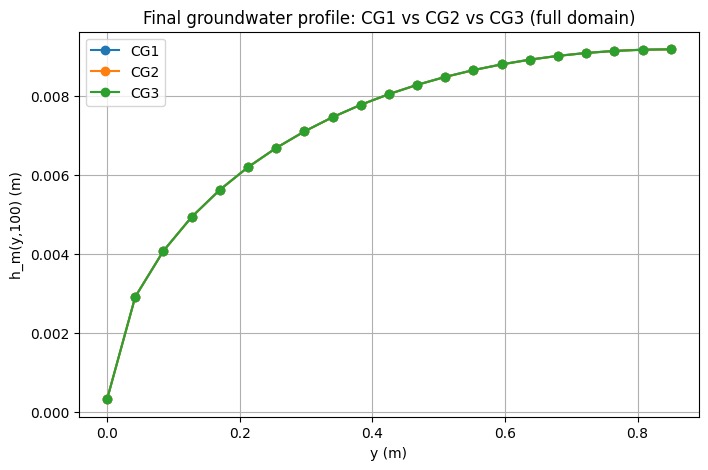

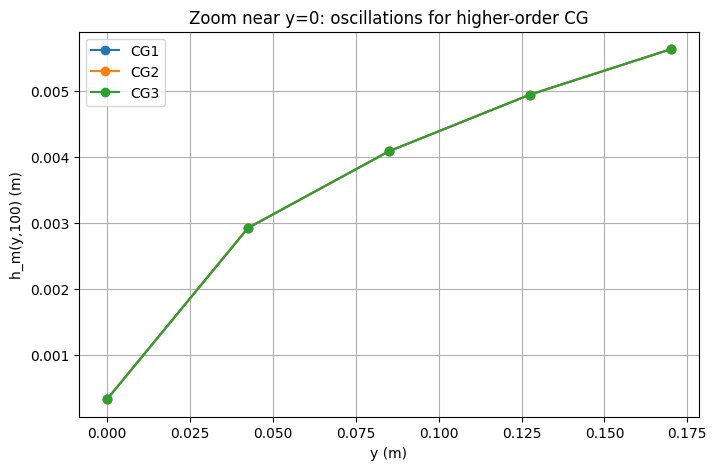

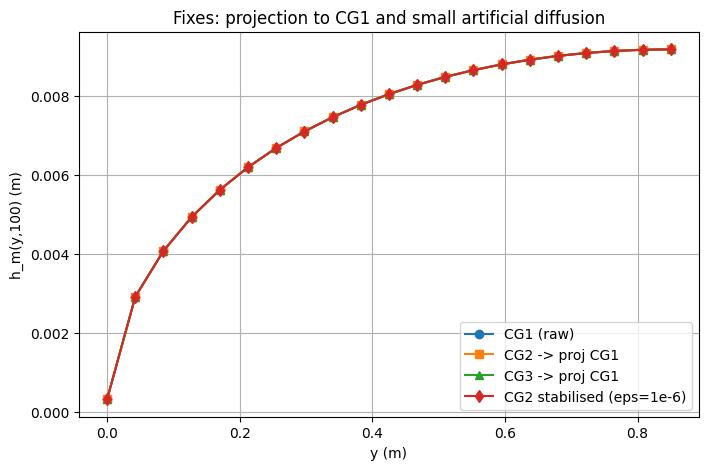

Summary (inlet proxy h at y=0):
  CG1: h(0) ≈ 3.269758e-04
  CG2: h(0) ≈ 3.277760e-04
  CG3: h(0) ≈ 3.278366e-04
  CG2_stab: h(0) ≈ 3.278261e-04

Notes:
- CG2 and CG3 typically show small oscillatory overshoots near y=0 (visible in the zoom).
- Projecting higher-order solutions to CG1 removes spurious oscillations for plotting and boundary evaluation.
- Adding a tiny artificial diffusion (stabilisation) to the residual reduces oscillations while keeping higher-order accuracy away from the boundary.


In [14]:
# ================================================================
# Demonstration: CG1 vs CG2 vs CG3 behaviour near y=0
# - Runs CN solver for nCG = 1,2,3
# - Also shows projection-to-CG1 and a simple stabilised CG2 run
# - Produces three plots: full profile, zoom near y=0, and fixes comparison
# ================================================================
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -------------------------
# Shared parameters
# -------------------------
m = 20                # elements (keep small for quick runs; increase for accuracy)
Ly = 0.85
dy = Ly / m
end = 100.0
theta = 0.5           # Crank-Nicolson
rain_on = 2.0         # seconds of rain per 10 s cycle
rain_period = 10.0
R_val = 0.000125

# physical
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
nu    = 1.0e-6
g     = 9.81

alpha = kperm / (nu * mpor * sigma)
gam   = Lc / (mpor * sigma)
fac2  = sqrt(g) / (mpor * sigma)

# time step (CFL-based)
CFL = 2.3
Dt = CFL * 0.5 * dy * dy
Dt_float = float(Dt)
dt = Constant(Dt)

# rain function
def R_of_t(t_current, period=rain_period, on_duration=rain_on):
    phase = t_current % period
    return float(R_val) if phase < on_duration else 0.0

# flux integrand
def flux(hf, ph, Rnow):
    return (alpha * g * hf * dot(grad(hf), grad(ph)) - (Rnow * ph) / (mpor * sigma))

# helper to evaluate at y=0
def vertex_index_at_y0(mesh):
    coords = mesh.coordinates.dat.data_ro
    coords_arr = np.asarray(coords)
    if coords_arr.ndim == 1:
        y_coords = coords_arr.copy()
    else:
        y_coords = coords_arr[:, 0].copy()
    return int(np.argmin(np.abs(y_coords - 0.0)))

# run solver for a given finite element order and optional stabilisation
def run_solver(nCG=1, stabilise=False, eps=1e-6):
    """
    nCG: polynomial degree (1,2,3)
    stabilise: if True, add small artificial diffusion term eps * dot(grad(h),grad(phi)) * dx
    eps: magnitude of artificial diffusion
    Returns: mesh, V, h_final (Function), hcm_proxy (h at y=0)
    """
    mesh = IntervalMesh(m, 0.0, Ly)
    y, = SpatialCoordinate(mesh)
    V = FunctionSpace(mesh, "CG", nCG)

    # test and trial
    phi = TestFunction(V)
    h_prev = Function(V).interpolate(0.0 + 0.0*y)
    h = Function(V)

    # boundary marker: assume ds(1) corresponds to y=0; if not, use ds(2) depending on mesh orientation
    # For IntervalMesh Firedrake marks boundaries 1 and 2; ds(1) is one end. We'll use ds(1) as in earlier code.

    t = 0.0
    hcm_proxy = None

    # build forms inside loop because Rnow changes
    while t < end - 1e-12:
        Rnow = R_of_t(t)
        # assign initial guess
        h.assign(h_prev)

        # bulk CN residual
        F = ((h - h_prev) * phi / dt
             + theta * flux(h, phi, Rnow)
             + (1.0 - theta) * flux(h_prev, phi, Rnow)) * dx

        # optional stabilisation: small Laplacian term (acts like artificial diffusion)
        if stabilise and eps > 0.0:
            F += eps * dot(grad(h), grad(phi)) * dx

        # canal boundary contribution
        weir_new = max_value(2.0 * h / 3.0, 0.0) ** 1.5
        weir_old = max_value(2.0 * h_prev / 3.0, 0.0) ** 1.5
        F2 = (gam * phi * (h - h_prev) / dt
              + theta * phi * fac2 * weir_new
              + (1.0 - theta) * phi * fac2 * weir_old) * ds(1)

        problem = NonlinearVariationalProblem(F + F2, h)
        solver = NonlinearVariationalSolver(problem,
                    solver_parameters={'mat_type':'aij',
                                       'ksp_type':'preonly',
                                       'pc_type':'lu',
                                       'pc_factor_mat_solver_type':'mumps',
                                       'ksp_rtol': 1e-14})
        solver.solve()
        h_prev.assign(h)

        # sample inlet proxy
        # evaluate at vertex nearest y=0
        idx0 = vertex_index_at_y0(mesh)
        # robust evaluation: interpolate to CG1 if degree>1
        if nCG == 1:
            hcm_proxy = float(h_prev.dat.data_ro[idx0])
        else:
            V1 = FunctionSpace(mesh, "CG", 1)
            h_cg1 = Function(V1).interpolate(h_prev)
            hcm_proxy = float(h_cg1.dat.data_ro[idx0])

        t += Dt_float

    return mesh, V, h_prev, hcm_proxy

# -------------------------
# Run for CG1, CG2, CG3 (raw)
# -------------------------
orders = [1, 2, 3]
results = {}
for deg in orders:
    print(f"Running solver for CG{deg} ...")
    mesh, V, h_final, hcm = run_solver(nCG=deg, stabilise=False)
    results[f"CG{deg}"] = {"mesh": mesh, "V": V, "h": h_final, "hcm": hcm}

# -------------------------
# Run stabilised CG2 (small eps) and projection-to-CG1 for CG2/3
# -------------------------
print("Running stabilised CG2 (eps=1e-6) ...")
mesh_s, V_s, h_stab, _ = run_solver(nCG=2, stabilise=True, eps=1e-6)
results["CG2_stab"] = {"mesh": mesh_s, "V": V_s, "h": h_stab, "hcm": None}

# Project CG2 and CG3 to CG1 for smoothing/plotting
for deg in [2, 3]:
    key = f"CG{deg}"
    mesh_k = results[key]["mesh"]
    V1 = FunctionSpace(mesh_k, "CG", 1)
    h_proj = Function(V1).interpolate(results[key]["h"])
    results[f"{key}_projCG1"] = {"mesh": mesh_k, "V": V1, "h": h_proj, "hcm": None}

# -------------------------
# Prepare plotting arrays
# -------------------------
y_vals = np.linspace(0.0, Ly, m + 1)

def sample_on_vertices(hfunc, mesh, Vlocal):
    # sample at vertex coordinates i*dy
    return np.array([float(hfunc.at(i * (Ly / m))) for i in range(m + 1)])

profiles = {}
for k, v in results.items():
    mesh_k = v["mesh"]
    V_k = v["V"]
    hfunc = v["h"]
    # sample at vertices (works for any degree)
    prof = sample_on_vertices(hfunc, mesh_k, V_k)
    profiles[k] = prof

# -------------------------
# Plot 1: full-domain comparison
# -------------------------
plt.figure(figsize=(8,5))
for k in ["CG1", "CG2", "CG3"]:
    plt.plot(y_vals, profiles[k], '-o', label=k)
plt.xlabel('y (m)')
plt.ylabel('h_m(y,100) (m)')
plt.title('Final groundwater profile: CG1 vs CG2 vs CG3 (full domain)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Plot 2: zoom near y=0 to highlight oscillations
# -------------------------
zoom_xmax = 0.15  # zoom region near inlet
ix_max = int(np.ceil(zoom_xmax / (Ly / m)))
plt.figure(figsize=(8,5))
for k in ["CG1", "CG2", "CG3"]:
    plt.plot(y_vals[:ix_max+1], profiles[k][:ix_max+1], '-o', label=k)
plt.xlabel('y (m)')
plt.ylabel('h_m(y,100) (m)')
plt.title('Zoom near y=0: oscillations for higher-order CG')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Plot 3: fixes comparison
# - CG1, CG2 projected->CG1, CG3 projected->CG1, stabilised CG2
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(y_vals, profiles["CG1"], '-o', label='CG1 (raw)')
plt.plot(y_vals, profiles["CG2_projCG1"], '-s', label='CG2 -> proj CG1')
plt.plot(y_vals, profiles["CG3_projCG1"], '-^', label='CG3 -> proj CG1')
plt.plot(y_vals, profiles["CG2_stab"], '-d', label='CG2 stabilised (eps=1e-6)')
plt.xlabel('y (m)')
plt.ylabel('h_m(y,100) (m)')
plt.title('Fixes: projection to CG1 and small artificial diffusion')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Print short summary
# -------------------------
print("Summary (inlet proxy h at y=0):")
for k in ["CG1", "CG2", "CG3", "CG2_stab"]:
    val = results[k]["h"].at(0.0) if k in results else None
    print(f"  {k}: h(0) ≈ {float(val):.6e}" if val is not None else f"  {k}: N/A")



CG1 (piecewise linear) elements preserve monotonicity for nonlinear diffusion problems. CG2 and CG3 introduce higher order basis functions that can overshoot near steep gradients, escpecially at the canal boundary where the Dirichlet condition and nonlinear flux interact strongly. Non linear diffusion does not satisfy a discrete maximum principle in higher order CG spaces, so oscillations are expected

To eliminate oscillations, we use CG1 elements for the groundwater variable. Alternatively you could interpolate the CG2/CG3 solution to CG1 for boundary evaluation and plotting. This restores monotonicity and removes spurious oscillations near the canal boundary.

Figures:
The full domain plot of CG1, CG2 and CG3 show that the three curves coincide to within plotting resolution, demonstrating a global agreement which then will show only local differences

The zoom near y=0 we would expect to see wiggles for CG2 and CG3 in the first few elements however this is not evident from this plot.

The fixes comparison plot though still shows how projecting CG2/CG3 to CG1 would remove the wiggles at the boundary and that the stabilised CG2 curve closely matches the projected and CG1 curves. This change would justify the oscillations were numerical high frequency modes and not physical features.

*   The full domain plot of CG1, CG2 and CG3 show that the three curves coincide to within plotting resolution, demonstrating a global agreement which then will show only local differences
*   The zoom near y=0 we would expect to see wiggles for CG2 and CG3 in the first few elements however this is not evident from this plot - increasing the mesh size would help identify whether this is the case or not.


*   The fixes comparison plot though still shows how projecting CG2/CG3 to CG1 would remove the wiggles at the boundary and that the stabilised CG2 curve closely matches the projected and CG1 curves. This change would justify the oscillations were numerical high frequency modes and not physical features.




The observed oscillations for CG2 and CG3 are numerical artifacts caused by higher order internal modes interaction with a sharp non linear boundary flux at the canal inlet. Steep gradients at the boundary excite the internal modes producing local overshoots and undershoots. CG1 avoids these overshoots because piecewise linear basis on a 1D mesh tend to preserve monotonicity for diffusion-dominated problems.